# Data Exploration

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import plot_importance, plot_tree

from sklearn.metrics import r2_score

In [3]:
# Import csv file
energy = pd.read_csv("Victoria Oct 2018 - September 2019 data - working.csv", index_col=[0], parse_dates=[0])

In [4]:
energy.shape

(17520, 1)

In [5]:
energy.head(5)

,TOTALDEMAND
SETTLEMENTDATE,
2018-01-10 00:30:00,4690.96
2018-01-10 01:00:00,4546.85
2018-01-10 01:30:00,4405.95
2018-01-10 02:00:00,4235.15
2018-01-10 02:30:00,4101.54


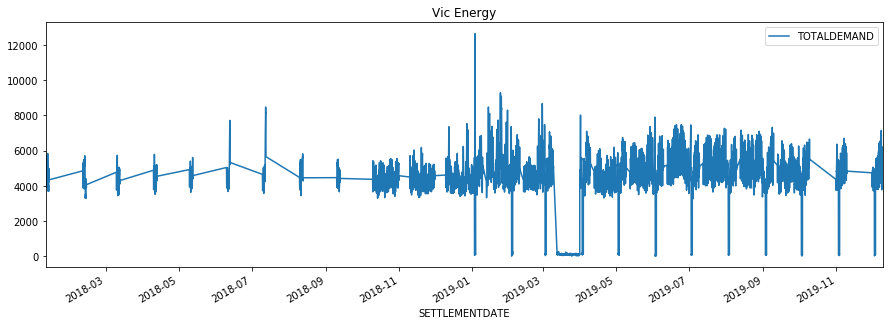

In [6]:
energy.plot(style='-', figsize=(15,5), title='Vic Energy');

# Building Training/ Test Samples
Data after 2015 will be used as validation set

In [7]:
split_date = '06-30-2019'
energy_train = energy.loc[energy.index <= split_date].copy()
energy_test = energy.loc[energy.index > split_date].copy()

In [8]:
len(energy_train)

12193

In [9]:
len(energy_test)

5327

In [10]:
print(energy_test)

                     TOTALDEMAND
SETTLEMENTDATE                  
2019-07-01 00:00:00      4252.29
2019-07-01 00:30:00      4055.86
2019-07-01 01:00:00      3922.27
2019-07-01 01:30:00      3854.32
2019-07-01 02:00:00      3698.65
...                          ...
2019-09-30 21:30:00      5732.79
2019-09-30 22:00:00      5545.75
2019-09-30 22:30:00      5225.72
2019-09-30 23:00:00      5038.76
2019-09-30 23:30:00      5185.91

[5327 rows x 1 columns]


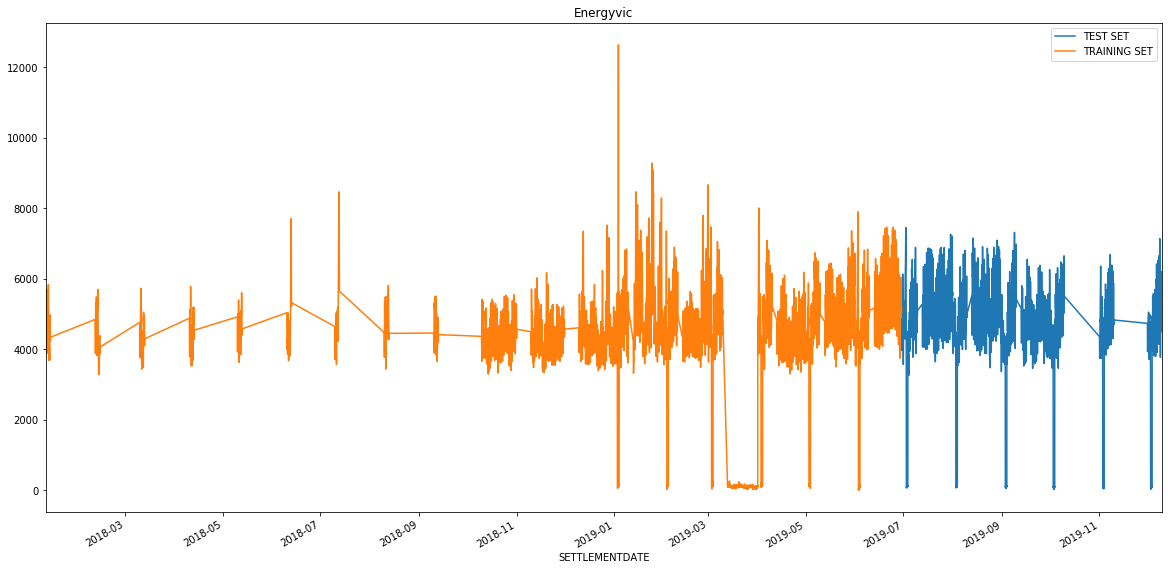

In [11]:
energy_test \
    .rename(columns={'TOTALDEMAND': 'TEST SET'}) \
    .join(energy_train.rename(columns={'TOTALDEMAND': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(20,10), title='Energyvic', style='-');

# Features Engineering

In [12]:
def create_features(energy, label=None):
    energy['date'] = energy.index
    energy['hour'] = energy['date'].dt.hour
    energy['dayofweek'] = energy['date'].dt.dayofweek
    energy['month'] = energy['date'].dt.month
    energy['quarter'] = energy['date'].dt.quarter
    energy['year'] = energy['date'].dt.year
    energy['dayofyear'] = energy['date'].dt.dayofyear
    energy['dayofmonth'] = energy['date'].dt.day
    energy['weekofyear'] = energy['date'].dt.weekofyear
    
    X = energy[['hour', 'dayofweek','month', 'quarter', 'year', 'dayofyear',
            'dayofmonth', 'weekofyear']]
    if label:
        y = energy[label]
        return X, y
    return X

In [13]:
len(X_test)

NameError: name 'X_test' is not defined

In [14]:
X_train, y_train = create_features(energy_train, label='TOTALDEMAND')
X_test, y_test = create_features(energy_test, label='TOTALDEMAND')

# Build XGBoost Model

In [15]:
reg = xgb.XGBRegressor(n_estimators=300)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds = 50,
        verbose = False)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:01:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

# Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the day of year was most commonly used to split trees, while dayofmonth and hour came in next.

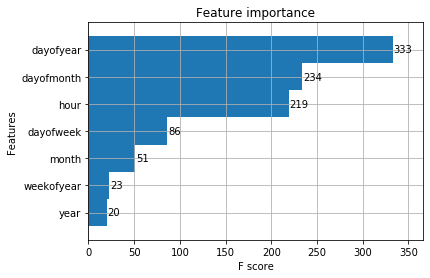

In [16]:
plot_importance(reg, height=1);

# Forecast on Test Set

In [17]:
energy_test['energy_Prediction'] = reg.predict(X_test)

In [18]:
energy_test.head(5)

,TOTALDEMAND,date,hour,dayofweek,month,quarter,year,dayofyear,dayofmonth,weekofyear,energy_Prediction
SETTLEMENTDATE,,,,,,,,,,,
2019-07-01 00:00:00,4252.29,2019-07-01 00:00:00,0,0,7,3,2019,182,1,27,4536.327637
2019-07-01 00:30:00,4055.86,2019-07-01 00:30:00,0,0,7,3,2019,182,1,27,4536.327637
2019-07-01 01:00:00,3922.27,2019-07-01 01:00:00,1,0,7,3,2019,182,1,27,4297.670898
2019-07-01 01:30:00,3854.32,2019-07-01 01:30:00,1,0,7,3,2019,182,1,27,4297.670898
2019-07-01 02:00:00,3698.65,2019-07-01 02:00:00,2,0,7,3,2019,182,1,27,4109.819336


In [19]:
energy_all = pd.concat([energy_test, energy_train], sort = False)

In [20]:
energy_all.shape

(17520, 11)

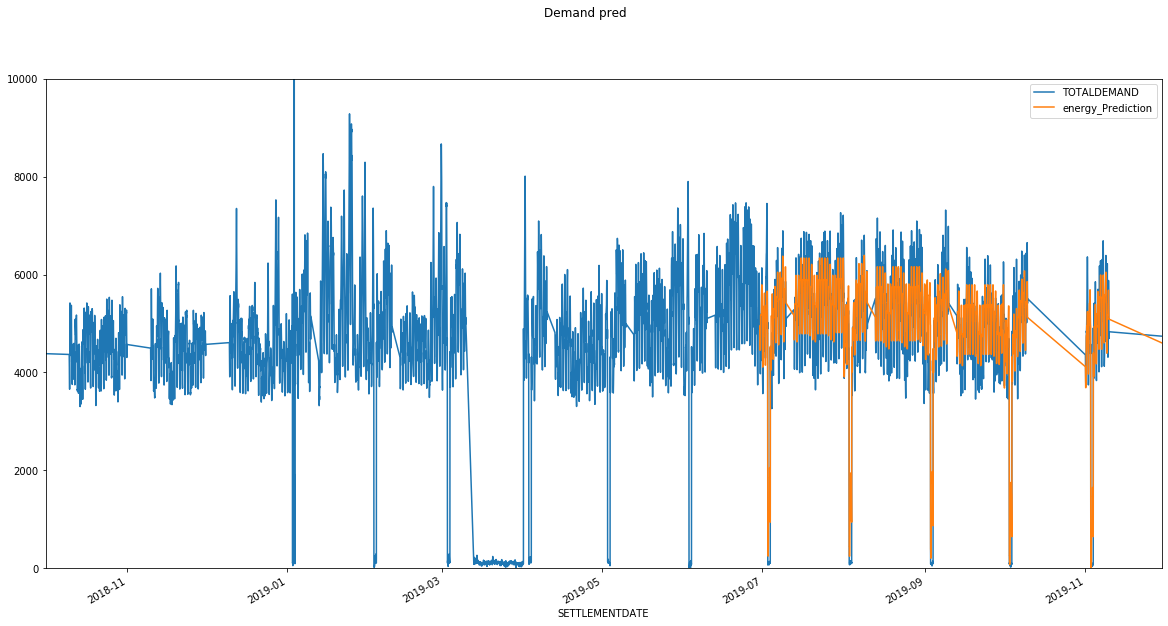

In [21]:
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(20)

_ = energy_all[['TOTALDEMAND','energy_Prediction', ]].plot(ax=ax, style=['-','-'])
ax.set_ylim(0, 10000)
ax.set_xbound(lower='10-01-2018', upper = '11-30-2019')
plot = plt.suptitle('Demand pred')

energy_all[['TOTALDEMAND', 'energy_Prediction']].plot(figsize=(15,5));

# Check first week of August predictions

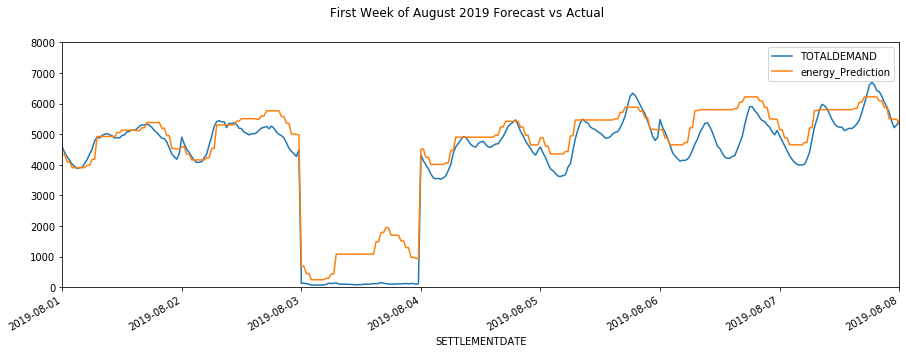

In [22]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

_ = energy_all[['TOTALDEMAND', 'energy_Prediction']].plot(ax=ax, style=['-', '-'])
ax.set_xbound(lower='08-01-2019', upper='08-08-2019')
ax.set_ylim(0, 8000)

plot = plt.suptitle('First Week of August 2019 Forecast vs Actual')

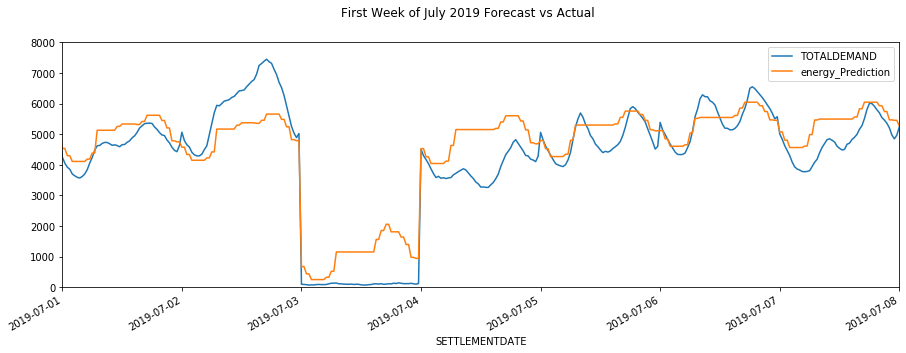

In [35]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

_ = energy_all[['TOTALDEMAND', 'energy_Prediction']].plot(ax=ax, style=['-', '-'])
ax.set_xbound(lower='07-01-2019', upper='07-08-2019')
ax.set_ylim(0, 8000)

plot = plt.suptitle('First Week of July 2019 Forecast vs Actual')

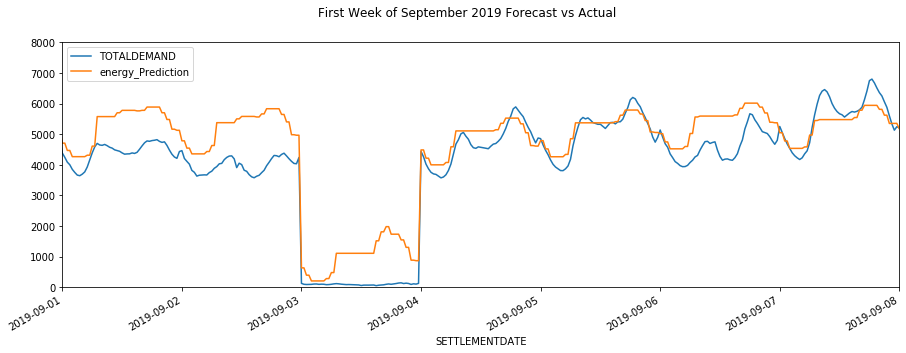

In [36]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

_ = energy_all[['TOTALDEMAND', 'energy_Prediction']].plot(ax=ax, style=['-', '-'])
ax.set_xbound(lower='09-01-2019', upper='09-08-2019')
ax.set_ylim(0, 8000)

plot = plt.suptitle('First Week of September 2019 Forecast vs Actual')

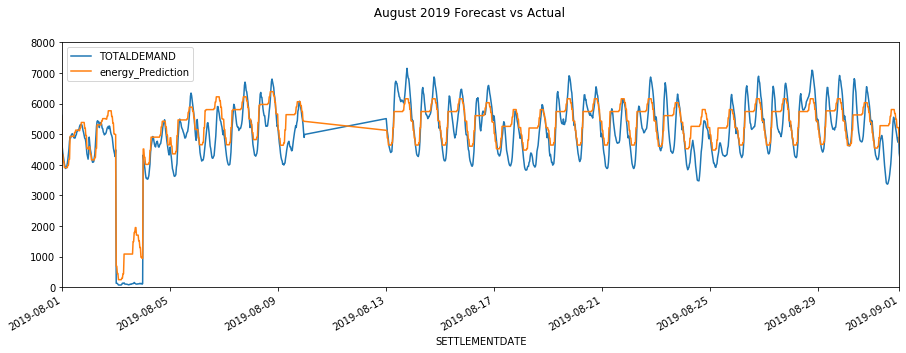

In [23]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

_ = energy_all[['TOTALDEMAND', 'energy_Prediction']].plot(ax=ax, style=['-', '-'])
ax.set_xbound(lower='08-01-2019', upper='09-01-2019')
ax.set_ylim(0, 8000)

plot = plt.suptitle(' August 2019 Forecast vs Actual')

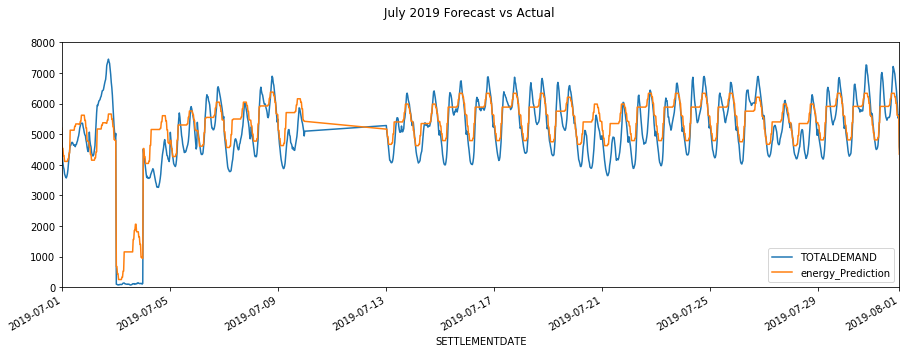

In [37]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

_ = energy_all[['TOTALDEMAND', 'energy_Prediction']].plot(ax=ax, style=['-', '-'])
ax.set_xbound(lower='07-01-2019', upper='08-01-2019')
ax.set_ylim(0, 8000)

plot = plt.suptitle(' July 2019 Forecast vs Actual')

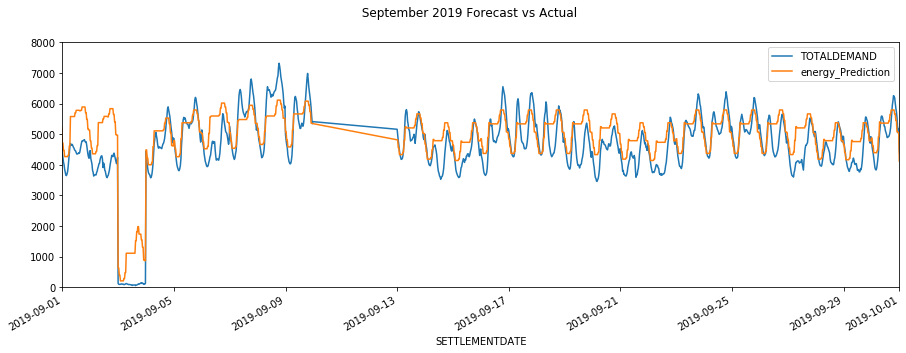

In [39]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

_ = energy_all[['TOTALDEMAND', 'energy_Prediction']].plot(ax=ax, style=['-', '-'])
ax.set_xbound(lower='09-01-2019', upper='10-01-2019')
ax.set_ylim(0, 8000)

plot = plt.suptitle(' September 2019 Forecast vs Actual')

# Evaluate the Performance

In [24]:
# The MAPE (Mean Absolute Percent Error) measures the size of the error
# in percentage terms.
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [25]:
# Make predictions using the training and testing set
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

In [26]:
print('R^2   train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

print('MSE   train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))

print('RMSE  train: %.2f, test: %.2f' %
      (np.sqrt(mean_squared_error(y_train, y_train_pred)),
       np.sqrt(mean_squared_error(y_test, y_test_pred))))

print('MAE   train: %.2f, test: %.2f' %
      (mean_absolute_error(y_train, y_train_pred),
       mean_absolute_error(y_test, y_test_pred)))

print('MAPE  train: %.2f, test: %.2f' %
      (mean_absolute_percentage_error(y_train, y_train_pred),
       mean_absolute_percentage_error(y_test, y_test_pred)))

R^2   train: 0.90, test: 0.82
MSE   train: 265199.42, test: 345647.81
RMSE  train: 514.98, test: 587.92
MAE   train: 351.19, test: 459.71
MAPE  train: 40.51, test: 61.91


In [43]:
from math import sqrt
import sklearn.metrics as metrics
rms = sqrt(mean_squared_error(y_test, y_test_pred))
print('RMSE= ',rms)
mae=metrics.mean_absolute_error(y_test, y_test_pred)
print('MAE= ',mae)

RMSE=  587.9181976774288
MAE=  459.71063934326173


# Check Best and Worst Predicted Day

In [27]:
energy_test['error'] = energy_test['TOTALDEMAND'] - energy_test['energy_Prediction']

In [28]:
energy_test['abs_error'] = energy_test['error'].apply(np.abs)

In [29]:
error_by_day = energy_test.groupby(['year','month','dayofmonth']) \
    .mean()[['TOTALDEMAND', 'energy_Prediction', 'error', 'abs_error']]

In [30]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

TOTALDEMAND  energy_Prediction        error  \
year month dayofmonth                                                
2019 9     2           3986.198750        5205.650391 -1219.451498   
     7     4           3899.601042        4927.587402 -1027.986554   
           3            102.087083        1081.659302  -979.572160   
     9     3             94.601667        1026.218994  -931.617358   
     8     3            106.020208        1026.797485  -920.777247   
     9     1           4395.143125        5288.133789  -892.990847   
     12    3             75.001875         890.244995  -815.243096   
     10    2           3949.446667        4746.119141  -796.672311   
     9     6           4611.225833        5397.081543  -785.855872   
     10    3             73.930000         818.900085  -744.970107   

                         abs_error  
year month dayofmonth               
2019 9     2           1219.451498  
     7     4           1027.986554  
           3            979.572160  
     9     3            931.617358  
     8     3            920.777247  
     9     1            892.990847  
     12    3            815.243096  
     10    2            796.672311  
     9     6            790.845453  
     10    3            745.436177


From the data, we observe that:

number 1 worst day, September 2nd, 2019 
number 2 worst day, July 4th, 2019
number 3 worst day, July 3rd, 2019


In [31]:
# Best absolute predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

TOTALDEMAND  energy_Prediction       error   abs_error
year month dayofmonth                                                        
2019 8     1           4726.920833        4757.119629  -30.198684  154.737968
     10    1           4503.278958        4454.945312   48.333809  155.425871
     9     5           5083.472292        5162.480957  -79.008787  189.316446
           24          5241.138750        5177.709473   63.429440  216.743969
     10    7           5295.529792        5275.436523   20.093248  223.663674
     9     13          5014.542292        5079.571289  -65.029160  228.757986
           25          5179.288750        5177.709473    1.579440  230.625411
     8     20          5476.606250        5530.443359  -53.836967  232.101160
           4           4522.651458        4773.076172 -250.424836  253.289435
     7     17          5639.159167        5686.800293  -47.640943  256.977113

In [32]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

TOTALDEMAND  energy_Prediction        error  \
year month dayofmonth                                                
2019 9     2           3986.198750        5205.650391 -1219.451498   
     7     4           3899.601042        4927.587402 -1027.986554   
           3            102.087083        1081.659302  -979.572160   
     9     3             94.601667        1026.218994  -931.617358   
     8     3            106.020208        1026.797485  -920.777247   
     9     1           4395.143125        5288.133789  -892.990847   
     7     2           5899.731042        5008.878418   890.852481   
     12    3             75.001875         890.244995  -815.243096   
     10    2           3949.446667        4746.119141  -796.672311   
     9     6           4611.225833        5397.081543  -785.855872   

                         abs_error  
year month dayofmonth               
2019 9     2           1219.451498  
     7     4           1027.986554  
           3            979.572160  
     9     3            931.617358  
     8     3            920.777247  
     9     1            892.990847  
     7     2            890.852481  
     12    3            815.243096  
     10    2            796.672311  
     9     6            790.845453

# Plot best and worst predicted days

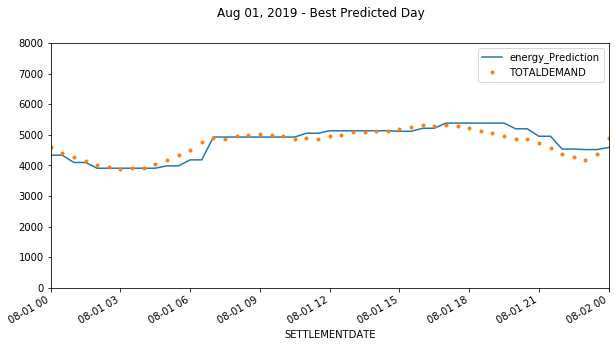

In [33]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)

_ = energy_all[['energy_Prediction', 'TOTALDEMAND']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 8000)
ax.set_xbound(lower='08-01-2019', upper = '08-02-2019')
plot = plt.suptitle('Aug 01, 2019 - Best Predicted Day')

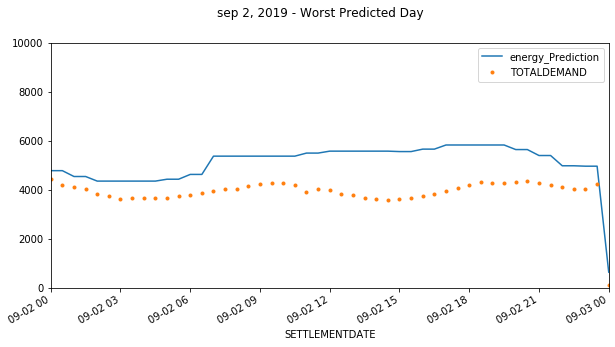

In [34]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)

_ = energy_all[['energy_Prediction', 'TOTALDEMAND']].plot(ax=ax, style=['-','.'])
ax.set_ylim(0, 10000)
ax.set_xbound(lower='09-02-2019', upper = '09-03-2019')
plot = plt.suptitle('sep 2, 2019 - Worst Predicted Day')